# Train a Simplicial Complex Net (SCoNe)

In this notebook, we will create and train a SCoNe neural network in the simplicial complex domain, as proposed in [[RGS21] (Roddenberry et. al : Principled Simplicial Neural Networks for Trajectory Prediction (2021))](http://proceedings.mlr.press/v139/roddenberry21a/roddenberry21a.pdf).

Following the original paper, we train a network to predict the next step in a trajectory on a ($2$-dimensional) simplicial complex. Note that we will spend some time generating the synthetic dataset consisting of trajectories. One should feel free to just run the code cells in the first section and skip ahead to the implementation and training of the neural network in section 2 to 4.


# Table of contents

1. [Dataset generation](#dataset)
    1. [Generating trajectories](#trajectories)
    2. [Creating PyTorch dataloaders](#dataloaders)
2. [Creating the Neural Network](#network)
3. [Training the Neural Network](#training)
4. [Evaluating the model on test data](#evaluating)
5. [Suggestions for further experimentation](#further)


The equations of one layer of this neural network are given by:

🟥 $\quad m^{(1 \rightarrow 0 \rightarrow 1)}_{y \rightarrow \{z\} \rightarrow x}  = (L_{\downarrow,1})_{xy} \cdot h_y^{t,(1)} \cdot \Theta^{t,(1 \rightarrow 0 \rightarrow 1)}$

🟥 $\quad m_{x \rightarrow x}^{(1 \rightarrow 1)}  = h_x^{t,(1)} \cdot \Theta^{t,(1 \rightarrow 1)}$

🟥 $\quad m_{y \rightarrow \{z\} \rightarrow x}^{(1 \rightarrow 2 \rightarrow 1)}  = (L_{\uparrow,1})_{xy} \cdot h_y^{t,(1)} \cdot \Theta^{t,(1 \rightarrow 2 \rightarrow 1)}$

🟧 $\quad m_{x}^{(1 \rightarrow 0 \rightarrow 1)} = \sum_{y \in \mathcal{L}_\downarrow(x)} m_{y \rightarrow \{z\} \rightarrow x}^{(1 \rightarrow 0 \rightarrow 1)}$

🟧 $\quad m_{x}^{(1 \rightarrow 2 \rightarrow 1)}  = \sum_{y \in \mathcal{L}_\uparrow(x)} m_{y \rightarrow \{z\} \rightarrow x}^{(1 \rightarrow 2 \rightarrow 1)}$

🟩 $\quad m_x^{(1)}  = m_{x}^{(1 \rightarrow 0 \rightarrow 1)} + m_{x \rightarrow x}^{(1 \rightarrow 1)} + m_{x}^{(1 \rightarrow 2 \rightarrow 1)}$

🟦 $\quad h_x^{t,(1)} = \sigma(m_x^{(1)})$

Where the notations are defined in [Papillon et al : Architectures of Topological Deep Learning: A Survey of Topological Neural Networks (2023)](https://arxiv.org/abs/2304.10031).

In [1]:
import random
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import toponetx as tnx
from toponetx.classes.simplicial_complex import SimplicialComplex
import networkx as nx
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
from torch.optim import Adam
from tqdm.notebook import tqdm
from scipy.spatial import Delaunay, distance

from topomodelx.nn.simplicial.scone import SCoNe

In [2]:
# Seed random generators
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Dataset generation <a name="dataset"></a>

We are going to generate a synthetic dataset consisting of trajectories on a simplicial complex. We will follow, more or less, the same construction done in [RGS21]. First, we uniformly sample $N$ points from the unit square $[0,1]^2$ and construct the Delaunay triangulation of this point cloud. We then define two disks inside the unit square and remove all $2$-simplicies with their centroid contained in either of these two disks. The remaining $2$-simplices are then used to define our simplicial complex. Note that the number of $0$-simplicies in the final simplicial complex is less than or equal to $N$.

In [3]:
def generate_complex(N: int = 100) -> tuple[SimplicialComplex, np.ndarray]:
    """
    Generate a simplicial complex of dimension 2 as follows:
        1. Uniformly sample N random points form the unit square and build the Delaunay triangulation.
        2. Delete triangles contained in some pre-defined disks.
    """
    points = np.random.uniform(0, 1, size=(N, 2))

    # Sort points by the sum of their coordinates
    c = np.sum(points, axis=1)
    order = np.argsort(c)
    points = points[order]

    tri = Delaunay(points)  # Create Delaunay triangulation

    # Remove triangles having centroid inside the disks
    disk_centers = np.array([[0.3, 0.7], [0.7, 0.3]])
    disk_radius = 0.15
    simplices = []
    indices_included = set()
    for simplex in tri.simplices:
        center = np.mean(points[simplex], axis=0)
        if ~np.any(distance.cdist([center], disk_centers) <= disk_radius, axis=1):
            # Centroid is not contained in some disk, so include it.
            simplices.append(simplex)
            indices_included |= set(simplex)

    # Re-index vertices before constructing the simplicial complex
    idx_dict = {i: j for j, i in enumerate(indices_included)}
    for i in range(len(simplices)):
        for j in range(3):
            simplices[i][j] = idx_dict[simplices[i][j]]

    sc = SimplicialComplex(simplices)
    coords = points[list(indices_included)]
    return sc, coords

To obtain a random simplicial complex, we simply call the above generating function.

In [4]:
# Generate simplicial complex
N = 150
sc, coords = generate_complex(N)

Here, `sc` is an instance of the `SimplicialComplex` class from `TopoNetX`, and `coords` contains the Euclidean coordinates of the vertices. We will use these coordinates to construct the trajectories based on shortest paths.

Before generating the trajectories, let us visualize the simplicial complex we just generated.

In [5]:
def plot_complex(sc: SimplicialComplex, coords: np.ndarray) -> None:
    """
    Given a simplicial complex of dimension 1 or 2, plot the simplices in the plane using the coordinates of the 0-simplices in coords.
    """
    # Plot triangles
    for idx in sc.skeleton(2):
        pts = np.array([coords[idx[0]], coords[idx[1]], coords[idx[2]]])
        poly = plt.Polygon(pts, color="green", alpha=0.25)
        plt.gca().add_patch(poly)

    # Plot edges
    start = coords[np.array(sc.skeleton(1))[:, 0]]
    end = coords[np.array(sc.skeleton(1))[:, 1]]
    plt.plot(
        np.vstack([start[:, 0], end[:, 0]]),
        np.vstack([start[:, 1], end[:, 1]]),
        color="black",
        alpha=0.5,
    )

    # Plot points
    plt.scatter(coords[:, 0], coords[:, 1], color="black", s=30)

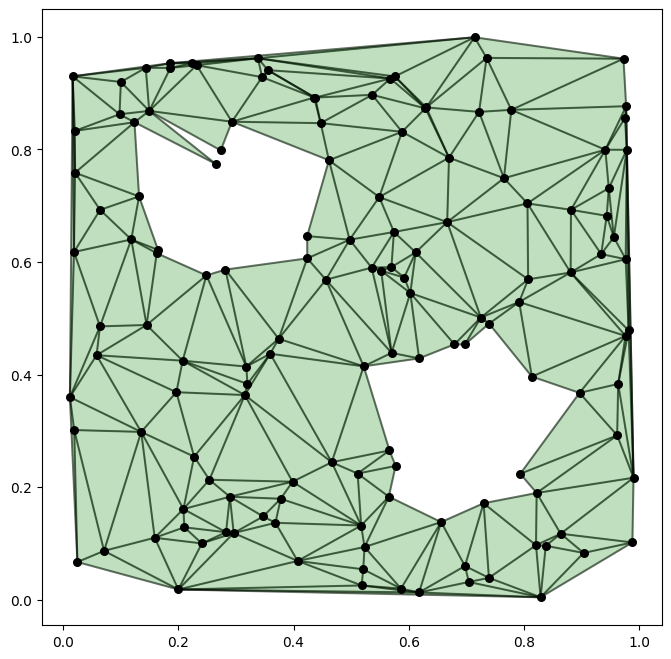

In [6]:
plot_complex(sc, coords)

## Generating trajectories <a name="trajectories"></a>

A **trajectory** on a simplicial complex $K$ is an ordered list of nodes $(i_1, i_2, \ldots, i_m)$ where each $[i_j, i_{j+1}]$ (or $[i_{j+1}, i_j]$) is an edge in $K$. Our network will take in a trajectory $(i_1, i_2, \ldots, i_{m-1})$ where the last node is removed, and the task will be to predict which of $i_{m-1}$'s neighbours is the true $i_m$ (i.e., $i_m$ is the ground truth in our supervised learning setup). Before feeding a trajectory to the network, we need to create a vector representation of it. We will do this in the next subsection when we create the PyTorch dataset.

Now, we want to construct our dataset of trajectories on the simplicial complex. First, we randomly pick triplets $(s,m,e)$ where $s$ is sampled from the lower left corner, $m$ is sampled from around the middle anti-diagonal and $e$ is sampled from the upper right corner. We then compute the shortest paths from $s$ to $m$ and from $m$ to $e$, respectively. Finally, we concatenate these two paths to form a trajectory from $s$ to $e$.

The parameter `n_max` determines the maximum number of trajectories to generate.

In [7]:
def generate_trajectories(
    sc: SimplicialComplex, coords: np.ndarray, n_max: int = 1000
) -> list[list[int]]:
    """
    Generate trajectories from nodes in the lower left corner to the upper right corner connected through a node in the middle.
    """
    # Get indices for start points in the lower left corner, mid points in the center region and end points in the upper right corner.
    N = len(sc)
    start_nodes = list(range(0, int(0.2 * N)))
    mid_nodes = list(range(int(0.4 * N), int(0.5 * N)))
    end_nodes = list(range(int(0.8 * N), N))
    all_triplets = list(product(start_nodes, mid_nodes, end_nodes))

    assert (
        len(all_triplets) >= n_max
    ), f"Only {len(all_triplets)} valid paths, but {n_max} requested. Try increasing the number of points in the simplicial complex."
    triplets = random.sample(all_triplets, n_max)

    # Compute pairwise distances and create a matrix representing the underlying graph.
    distance_matrix = distance.squareform(distance.pdist(coords))
    graph = sc.adjacency_matrix(0).toarray() * distance_matrix
    G = nx.from_numpy_array(graph)

    # Find shortest paths
    trajectories = []
    for s, m, e in triplets:
        path_1 = nx.shortest_path(G, s, m, weight="weight")
        path_2 = nx.shortest_path(G, m, e, weight="weight")
        trajectory = path_1[:-1] + path_2
        trajectories.append(trajectory)

    return trajectories

Let us generate 1200 trajectories to be used for training, validation and testing.

In [8]:
# Generate trajectories for training and evaluation
trajectories = generate_trajectories(sc, coords, 1200)

We can visualize one of the trajectories using the following function:

In [9]:
def plot_path(path: list[int], coords: np.ndarray) -> None:
    """
    Plot red arrows representing a trajectory.
    """
    x, y = coords[path, 0], coords[path, 1]
    plt.quiver(
        x[:-1],
        y[:-1],
        x[1:] - x[:-1],
        y[1:] - y[:-1],
        scale_units="xy",
        angles="xy",
        scale=1,
        color="red",
    )

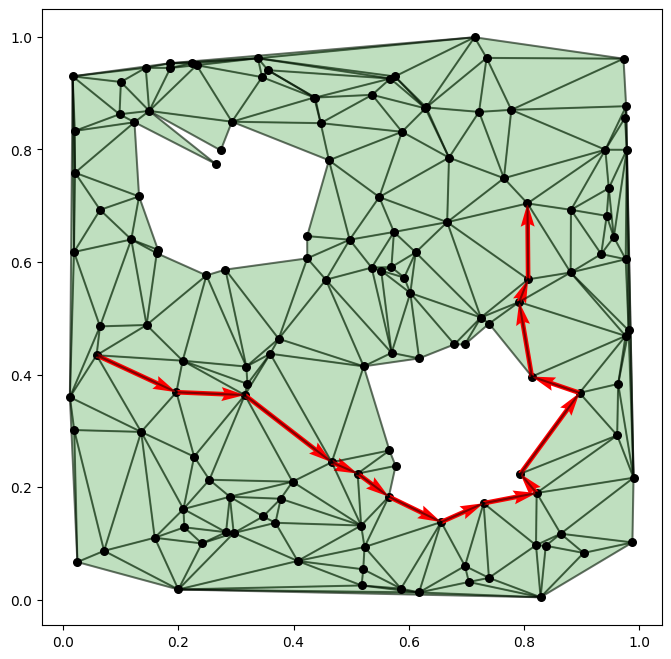

In [10]:
plot_complex(sc, coords)
plot_path(trajectories[0], coords)

## Creating PyTorch dataloaders <a name="dataloaders"></a>

We will now create a PyTorch dataset for our trajectories. For a trajectory $(i_1,i_2,\ldots,i_m)$, the dataset yields a triplet consisting of

1. `vectorized_trajectory` - a vector representation of the path $(i_1,i_2,\ldots,i_{m-1})$ (see description below),
2. `neigbors_mask` - a mask encoding the neighbors of $i_{m-1}$ and
3. `last_node` - the last vertex $i_m$ in the original trajectory, i.e., the ground truth label.


The vectorization step, where we turn a trajectory into a $1$-dimensional feature on the edges, is achieved as follows: Let $\mathcal{E}$ denote the set of edges in the simplicial complex with $\vert\mathcal{E}\vert=k$, and let $t=(i_1, i_2,\ldots, i_m)$ be a trajectory. The *vectorization of $t$* is the vector $(a_1, a_2, \ldots, a_k)\in\mathbb{R}^k$ where for all $0\leq j\leq k$ we set 

- $a_j=+1$ if $[i_n, i_{n+1}]\in\mathcal{E}$ for some $n$,
- $a_j=-1$ if $[i_{n+1}, i_n]\in\mathcal{E}$ for some $n$, and
- $a_j=0$ otherwise.

The neighborhood mask is used later in the forward pass of our model when we want to apply softmax, but only over the neighbors of $i_{m-1}$.

In [11]:
class TrajectoriesDataset(Dataset):
    def __init__(self, sc: SimplicialComplex, trajectories: list[list[int]]) -> None:
        self.trajectories = trajectories
        self.sc = sc
        self.adjacency = torch.Tensor(sc.adjacency_matrix(0).toarray())

        # Lookup table used to speed up vectorizing of trajectories
        self.edge_lookup_table = {}
        for i, edge in enumerate(self.sc.skeleton(1)):
            self.edge_lookup_table[edge] = (1, i)
            self.edge_lookup_table[edge[::-1]] = (-1, i)

    def __getitem__(
        self, index: int
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        trajectory = self.trajectories[index]
        vectorized_trajectory = self.vectorize_path(
            trajectory[:-1]
        )  # Discard the last node

        # Find neighbors of the last node in the trajectory (for use in the forward pass of SCoNe)
        neighbors_mask = (
            torch.Tensor(self.adjacency[trajectory[-2]] > 0).float().unsqueeze(-1)
        )

        last_node = torch.tensor(trajectory[-1])

        return vectorized_trajectory, neighbors_mask, last_node

    def __len__(self) -> int:
        return len(self.trajectories)

    def vectorize_path(self, path: list[int]) -> torch.Tensor:
        # Create a vector representation of a trajectory.
        m = len(self.sc.skeleton(1))
        c0 = torch.zeros((m, 1))
        for j in range(0, len(path) - 1):
            edge = (path[j], path[j + 1])
            sign, i = self.edge_lookup_table[edge]
            c0[i] = sign
        return c0

Using the above dataset class, we split the dataset $60/20/20$ into training, validation and test data, respectively. We set the batch size to $32$ and create data loaders which we will use later.

In [12]:
dataset = TrajectoriesDataset(sc, trajectories)

batch_size = 32
test = 0.2
val = 0.2
val_size = int(val * len(dataset))
test_size = int(test * len(dataset))
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)

# Creating the Neural Network <a name="network"></a>

We are now ready to define the trajectory prediction network using the `SCoNeLayer` class. First, we stack multiple SCoNe layers to obtain a map $C_1\to C_1$ where $C_1$ is the vector space of $1$-chains. Note that the feature dimension of the first and last SCoNe layer are both $1$. We then apply the last linear operation and the boundary operator $\partial_1$ going from $C_1$ to $C_0$. That is, we have now assigned a scalar value to each node in the simplicial complex. The final step consists of applying the softmax operator over the neighbors of $i_{m-1}$ and the highest scoring neighbor will be our prediction $\hat{i}_m$ for $i_m$.

# Training the Neural Network <a name="training"></a>

We will train the network for $10$ epochs using the Adam optimizer with hyper-parameters given below. We choose a network with $6$ hidden layers, each having feature dimension $16$. We use the negative log likelihood loss function penalizing the cases where $\hat{i}_m \neq i_m$.

In [13]:
# Hyper-parameters
epochs = 10
lr = 1e-3
weight_decay = 5e-5
betas = (0.9, 0.99)
hidden_dims = [16, 16, 16, 16, 16, 16]

model = SCoNe(sc, hidden_dims)
loss_function = nn.NLLLoss()  # Use NLL loss since we take softmax in the SCoNe network
optimizer = Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

# Training loop
training_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for epoch in range(epochs):
    print(f"Epoch {epoch+1:02}/{epochs:02}")
    training_losses = []
    correct = 0
    model.train()
    for batch in train_dl:
        # Train step
        traj, mask, last_nodes = batch
        optimizer.zero_grad()
        outputs = model(traj, mask)
        loss = loss_function(outputs, last_nodes.unsqueeze(-1))
        preds = torch.argmax(outputs, dim=1).squeeze()
        correct += torch.sum(preds == last_nodes)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())

    training_history["train_loss"].append(np.mean(training_losses))
    training_history["train_acc"].append(correct / len(train_ds))

    # Evaluate on validation data
    model.eval()
    correct = 0
    val_losses = []
    for batch in val_dl:
        traj, mask, last_nodes = batch
        outputs = model(traj, mask)
        loss = loss_function(outputs, last_nodes.unsqueeze(-1))
        preds = torch.argmax(outputs, dim=1).squeeze()
        correct += torch.sum(preds == last_nodes)
        val_losses.append(loss.item())

    training_history["val_loss"].append(np.mean(val_losses))
    training_history["val_acc"].append(correct / len(val_ds))

Epoch 01/10
Epoch 02/10
Epoch 03/10
Epoch 04/10
Epoch 05/10
Epoch 06/10
Epoch 07/10
Epoch 08/10
Epoch 09/10
Epoch 10/10


We take a quick look at the loss and accuracy plots for training and validation data to confirm that everything looks reasonable and the that the network is learning.

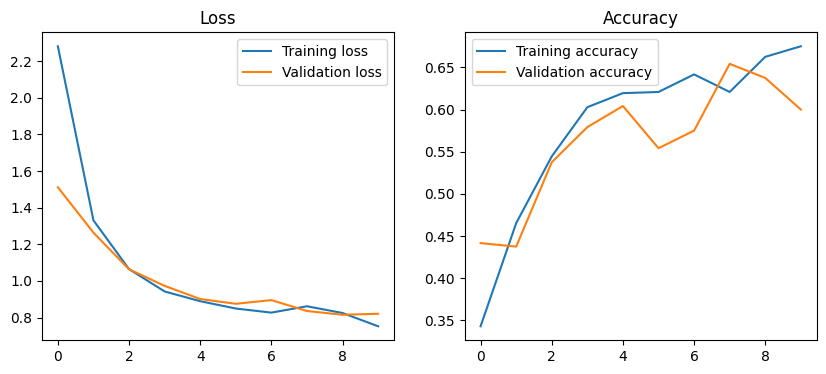

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
axes[0].set_title("Loss")
axes[0].plot(training_history["train_loss"], label="Training loss")
axes[0].plot(training_history["val_loss"], label="Validation loss")
axes[0].legend()
axes[1].set_title("Accuracy")
axes[1].plot(training_history["train_acc"], label="Training accuracy")
axes[1].plot(training_history["val_acc"], label="Validation accuracy")
axes[1].legend()
plt.show()

# Evaluating the model on test data <a name="evaluating"></a>

We now evaluate the final model on our test dataset. The average number of neighbors in our simplicial complex is approximately $5.5$, meaning that accuracies above $0.19$ should be better than random guessing.

In [15]:
model.eval()
correct = 0
for batch in test_dl:
    traj, mask, last_nodes = batch
    outputs = model(traj, mask)
    preds = torch.argmax(outputs, dim=1).squeeze()
    correct += torch.sum(preds == last_nodes)

print(f"Test accuracy: {correct / len(test_ds):.3f}")

Test accuracy: 0.613


# Suggestions for further experimentation <a name="further"></a>

- Try other update functions for the SCoNe layer such as ReLU or sigmoid (simply pass `update_func="relu"` or `update_func="sigmoid"` to the `SCoNeLayer` constructor). Does this affect performance?
- Try a different number of hidden layers and different hidden dimensions.
- Test the generalization capabilities of the network by making the test data differ more from the training data. For example, by reversing the trajectories in the test data.
- Change the underlying simplicial complex. Or, go to the [original implementation by the authors](https://github.com/nglaze00/SCoNe_GCN) and take a look at the real-world dataset called Ocean Drifters.